In [332]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [333]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [334]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.14.0


In [335]:
# Defining columns to use
columns_to_use = ["global_x", "global_y", "v_vel", "v_acc"] #using just 4 of them

# Defining chunk size for reading data
chunk_size = 100

# Initializing an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
velocity_dataset = pd.concat(data_chunks, ignore_index=True)

# trajectory_dataset = pd.read_csv(
#     "https://data.transportation.gov/resource/8ect-6jqj.csv")

#   names=["Vehicle_ID", "Frame_Id", "Total_Frames", "Global_Time", "Local_X",
#            "Local_Y", "Global_X", "Global_Y", "v_length", "v_Width", "v_Vel", 
#            "v_Acc", "Lane_ID", "O_Zone", "D_Zone", "Int_ID", "Section_ID", "Direction",
#            "Movement", "Preceding", "Following", "Space_Headway", "Time_Headway", "Location"]

In [336]:
velocity_dataset.shape

(1000, 4)

array([[<Axes: title={'center': 'global_x'}>,
        <Axes: title={'center': 'global_y'}>],
       [<Axes: title={'center': 'v_vel'}>,
        <Axes: title={'center': 'v_acc'}>]], dtype=object)

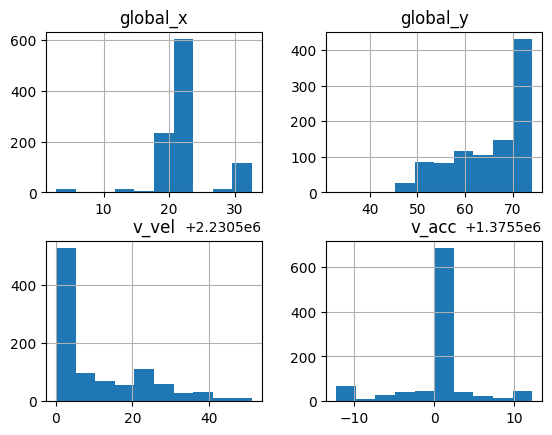

In [337]:
velocity_dataset.hist()

In [338]:
v_dataset = velocity_dataset.copy()
v_dataset.tail()

,global_x,global_y,v_vel,v_acc
995,2230522.629,1375574.155,0.0,0.0
996,2230522.629,1375574.155,0.0,0.0
997,2230522.629,1375574.155,0.0,0.0
998,2230522.629,1375574.155,0.0,0.0
999,2230522.629,1375574.155,0.0,0.0


In [339]:
# Define input features and labels (trying an alternate method: using train_test_split form sklearn)
input_features = ["global_x", "global_y", "v_acc"]
output_labels = ["v_vel"]

# Split dataset into input features and labels
X = v_dataset[input_features]
Y = v_dataset[output_labels]

# Split the dataset into training and test sets (80-20 split)
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of training and test sets
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

Train Features Shape: (800, 3)
Train Labels Shape: (800, 1)
Test Features Shape: (200, 3)
Test Labels Shape: (200, 1)


In [340]:
train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
global_x,800.0,2.230522e+06,4.214597,2230502.731,2.230520e+06,2230521.572,2230522.475,2230532.603
global_y,800.0,1.375565e+06,8.054386,1375532.938,1.375558e+06,1375567.959,1375572.436,1375574.155
v_acc,800.0,-2.365250e-01,4.432375,-12.270,0.000000e+00,0.000,0.000,12.270


In [341]:
train_labels.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
v_vel,800.0,10.702663,12.586978,0.0,0.24,4.225,20.58,51.3


In [342]:
feature_normalizer = tf.keras.layers.Normalization(axis=-1)
feature_normalizer.adapt(np.array(train_features))
print(feature_normalizer.mean.numpy())

[[2230521.8   1375565.2        -0.237]]


In [343]:
# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('Normalized:', feature_normalizer(first).numpy())

In [344]:
#normailizing the output layer
label_normalizer=layers.Normalization(axis=-1)
label_normalizer.adapt(train_labels)
print(label_normalizer.mean.numpy())

[[10.703]]


In [345]:
# Apply normalization to train and test features and labels
normalized_train_features = feature_normalizer(train_features)
normalized_test_features = feature_normalizer(test_features)
normalized_train_labels = label_normalizer(train_labels)
normalized_test_labels = label_normalizer(test_labels)

In [346]:
print("Feature Normalizer Mean:", feature_normalizer.mean.numpy())
print("Label Normalizer Mean:", label_normalizer.mean.numpy())

first = np.array(train_features[:1])
with np.printoptions(precision=2, suppress=True):
    print('Normalized Features:', feature_normalizer(first).numpy())
    print('Normalized Labels:', label_normalizer(np.array(train_labels[:1])).numpy())

Feature Normalizer Mean: [[2230521.8   1375565.2        -0.237]]
Label Normalizer Mean: [[10.703]]
Normalized Features: [[-0.71 -2.02  0.05]]
Normalized Labels: [[-0.55]]


In [347]:
def build_and_compile_model(norm_input):
  model = keras.Sequential([
      norm_input,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      #norm_output,  # Add normalization layer for output labels
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [348]:
dnn_model = build_and_compile_model(feature_normalizer)
dnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_19 (Normaliz  (None, 3)                 7         
 ation)                                                          
                                                                 
 dense_644 (Dense)           (None, 64)                256       
                                                                 
 dense_645 (Dense)           (None, 64)                4160      
                                                                 
 dense_646 (Dense)           (None, 64)                4160      
                                                                 
 dense_647 (Dense)           (None, 64)                4160      
                                                                 
 dense_648 (Dense)           (None, 64)                4160      
                                                     

In [349]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 40.6 s, sys: 4.11 s, total: 44.7 s
Wall time: 1min 25s


In [237]:
# %%time
# history = dnn_model.fit(
#     normalized_train_features,
#     train_labels,
#     validation_split=0.2,
#     verbose=0, epochs=100)

In [238]:
# %%time
# history = dnn_model.fit(
#     normalized_train_features,
#     normalized_train_labels,
#     validation_split=0.2,
#     verbose=0, epochs=100)

In [300]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,6.041904,5.992603,95
96,5.983880,6.095132,96
97,6.255401,6.521251,97
98,5.980024,6.072623,98
99,5.659808,5.561027,99


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [v_velocity]')
  plt.legend()
  plt.grid(True)

In [ ]:
plot_loss(history)

In [303]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
test_predictions = dnn_model.predict(test_features).flatten()

7/7 [==============================] - 1s 3ms/step


In [35]:
# A = tf.linspace(0.0, 250, 251)
# B = dnn_model.predict(A)

In [ ]:
# def plot_v_vel(A, B):
#   plt.scatter(train_features, train_labels, label='Data')
#   plt.plot(x, y, color='k', label='Predictions')
#   plt.xlabel('input_features')
#   plt.ylabel('vehicle_velocity')
#   plt.legend()

In [ ]:
# plot_v_vel(A, B)

In [54]:
# test_predictions = dnn_model.predict(test_features).flatten()

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [vehicle_velocity]')
# plt.ylabel('Predictions [vehicle_velocity]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

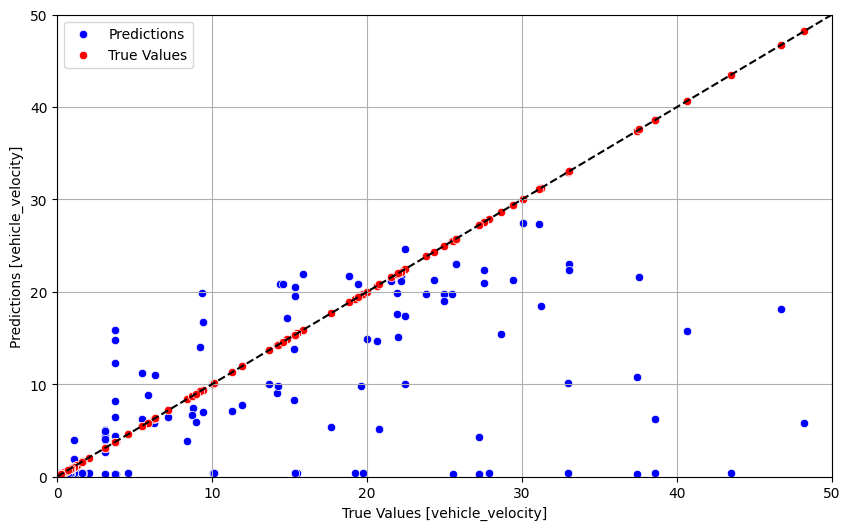

In [304]:
plot_data = pd.DataFrame({'True Values': test_labels.values.flatten(),
                          'Predictions': test_predictions})

plt.figure(figsize=(10, 6))
sns.scatterplot(x='True Values', y='Predictions', data=plot_data, color='blue', label='Predictions')
sns.scatterplot(x='True Values', y='True Values', data=plot_data, color='red', label='True Values')
plt.xlabel('True Values [vehicle_velocity]')
plt.ylabel('Predictions [vehicle_velocity]')
plt.legend()
plt.grid(True)
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, 'k--')  # Diagonal line
plt.show()

In [308]:
def predict_and_compare(index):
    inp_features = np.array([test_features.iloc[index]])
    
    true_label = test_labels.iloc[index].values[0]
    
    predicted_label = dnn_model.predict(inp_features)[0][0]
    
    error = abs(true_label - predicted_label) # Calculating the absolute error
    
    print(f"Input Features: {inp_features}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Error (absolute difference): {error}")


index_to_check = 160
predict_and_compare(index_to_check)

1/1 [==============================] - 0s 205ms/step
Input Features: [[2230522.249 1375570.665       0.49 ]]
True Label: 15.35
Predicted Label: 0.41623827815055847
Error (absolute difference): 14.933761721849441


In [ ]:
# def predict_and_compare(index):
#     inp_features = np.array([test_features.iloc[index]])
#     normalized_inp_features = normalizer(inp_features)
#     true_label = test_labels.iloc[index].values[0]
#     predicted_label = dnn_model.predict(normalized_inp_features)[0][0]
#         # Calculate the absolute error
#     error = abs(true_label - predicted_label)
    
#     print(f"Input Features: {inp_features}")
#     print(f"True Label: {true_label}")#
#     print(f"Predicted Label: {predicted_label}")
#     print(f"Error (absolute difference): {error}")

# index_to_check =30
# predict_and_compare(index_to_check)

In [309]:
max_index = velocity_dataset['v_vel'].idxmax()
print(max_index)

75


In [313]:
new_data = np.array([[2230180.8, 1375590.2, 0.37]])
new_label_prediction = dnn_model.predict(new_data)
print(f"New Predicted Label: {new_label_prediction}")

1/1 [==============================] - 1s 612ms/step
New Predicted Label: [[312.385]]
